In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from obp.ope import RegressionModel
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

from dataset.synthetic import SyntheticBanditDatasetWithCluster
from ope.regression import PairWiseRegression
from ope.meta import OffPolicyEvaluation
from ope.estimator import InversePropensityScore as IPS
from ope.estimator import MarginalizedIPS as MIPS
from ope.estimator import DoublyRobust as DR
from ope.estimator import DirectMethod as DM
from ope.estimator import OFFCEM
from ope.estimator_tuning import SLOPE
from utils.common import visualize_mean_squared_error
from utils.common import aggregate_simulation_results
from utils.lower_bound import estimate_student_t_lower_bound
from policy.function import gen_eps_greedy

In [2]:
def run_ope(
    val_data: dict,
    ope_estimators: list,
    action_dist: np.ndarray,
) -> np.ndarray:
    
    dim_context, n_actions, n_clusters = val_data["context"].shape[1], val_data["n_actions"], val_data["n_clusters"]

    # off policy evaluation
    ope = OffPolicyEvaluation(
        bandit_feedback=val_data,
        ope_estimators=ope_estimators,
    )
        
    ## train_reward_via_two_stage
    ### 1st-stage
    pairwise_model = PairWiseRegression(
        dim_context=dim_context,
        n_actions=n_actions,
        n_clusters=n_clusters,
        hidden_layer_size=(10, 10, 10),
        learning_rate_init=0.01,
        max_iter=10,
        #verbose=True
    )

    h_hat = pairwise_model.fit_predict(bandit_data=val_data)
        
    ### 2nd-stage
    reward = val_data["reward"]
    reward_residual = reward - h_hat[np.arange(val_size), val_data["action"]]
    cluster, phi_x_a = val_data["cluster"], val_data["phi_x_a"]

    reg_model = RegressionModel(
        n_actions=n_clusters,
        action_context=np.eye(n_clusters),
        base_model=MLP(
            hidden_layer_sizes=(10, 10, 10), 
            max_iter=10, 
            random_state=12345, 
            #verbose=True,
            learning_rate_init=0.1,
        )
    )

    g_hat = reg_model.fit_predict(
        context=val_data["context"],
        action=cluster,
        reward=reward_residual
    )[:, :, 0]

    f_hat_x_a_e = h_hat + g_hat[np.arange(val_size)[:, None], phi_x_a]
        
    ## one-step reward regression
    reg_model = RegressionModel(
        n_actions=n_actions,
        action_context=val_data["action_context_one_hot"],
        base_model=MLP(
            hidden_layer_sizes=(10, 10, 10), 
            max_iter=10, 
            random_state=12345, 
            #verbose=True,
            learning_rate_init=0.1,
        )
    )
    q_hat_x_a = reg_model.fit_predict(
        context=val_data["context"],
        action=val_data["action"],
        reward=val_data["reward"],
    )[:, :, 0]
        
    q_hat_dict = {
        "DM": q_hat_x_a,
        "DR": q_hat_x_a,
        "OFFCEM": f_hat_x_a_e,
        "OFFCEM + 1-step reg": q_hat_x_a,
        "OFFCEM (LC)": val_data["expected_reward"],
        "OFFCEM + cluster": np.zeros_like(q_hat_x_a),
    }
        
    estimated_policy_values = ope.estimate_policy_values(action_dist=action_dist, estimated_rewards=q_hat_dict)
    
    return estimated_policy_values

In [3]:
# setting
n_users=10
dim_context=10
n_actions=300
n_cat_per_dim=10
n_cat_dim=5
n_clusters=30
beta=-0.1
eps=0.3
reward_noise=1.0
random_state=12345
n_sim=100

In [4]:
# MSE with varying sample sizes in logged data

sample_sizes = [400, 600, 800, 1000]
ope_estimators = [
    IPS(estimator_name="IPS"),
    DM(estimator_name="DM"),
    DR(estimator_name="DR"),
    MIPS(estimator_name="MIPS (true)"),
    OFFCEM(estimator_name="OFFCEM"),
    OFFCEM(estimator_name="OFFCEM + 1-step reg"),
    OFFCEM(estimator_name="OFFCEM (LC)"),
    OFFCEM(estimator_name="OFFCEM + cluster")
]

In [5]:
dataset = SyntheticBanditDatasetWithCluster(
    n_users=n_users,
    dim_context=dim_context,
    n_actions=n_actions,
    n_cat_per_dim=n_cat_per_dim,
    n_cat_dim=n_cat_dim,
    n_clusters=n_clusters,
    beta=beta,
    reward_noise=reward_noise,
    random_state=random_state
)

# calc ground truth policy value for all users. ( V(\pi) = \mathbb{E}_{p(u)\pi(a|x_u)p(r|x_u,a)}[r] )
policy_value = dataset.calc_ground_truth_policy_value(pi_e=gen_eps_greedy(expected_reward=dataset.q_x_a, eps=eps))

result_df_list = []
for val_size in sample_sizes:
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"val_size={val_size}"):
        
        # obtain batch bandit data. ( (u_i, x_{u_i}, a_i, r_i) \sim \prod_{i=1}^{n} p(u_i)\pi_{b}(a_i|x_{u_i})p(r_i|x_{u_i}|a_i)  )
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        pi_e = gen_eps_greedy(
            expected_reward=val_data["expected_reward"],
            eps=eps,
        )
        
        estimated_policy_values = run_ope(
            val_data=val_data, ope_estimators=ope_estimators, action_dist=pi_e
        )
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list, policy_value=policy_value, x_value=val_size
    )
    result_df_list.append(result_df)

result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=400: 100% 100/100 [01:34<00:00,  1.06it/s]
val_size=600: 100% 100/100 [04:17<00:00,  2.57s/it]
val_size=800: 100% 100/100 [05:59<00:00,  3.59s/it]
val_size=1000: 100% 100/100 [08:49<00:00,  5.29s/it]


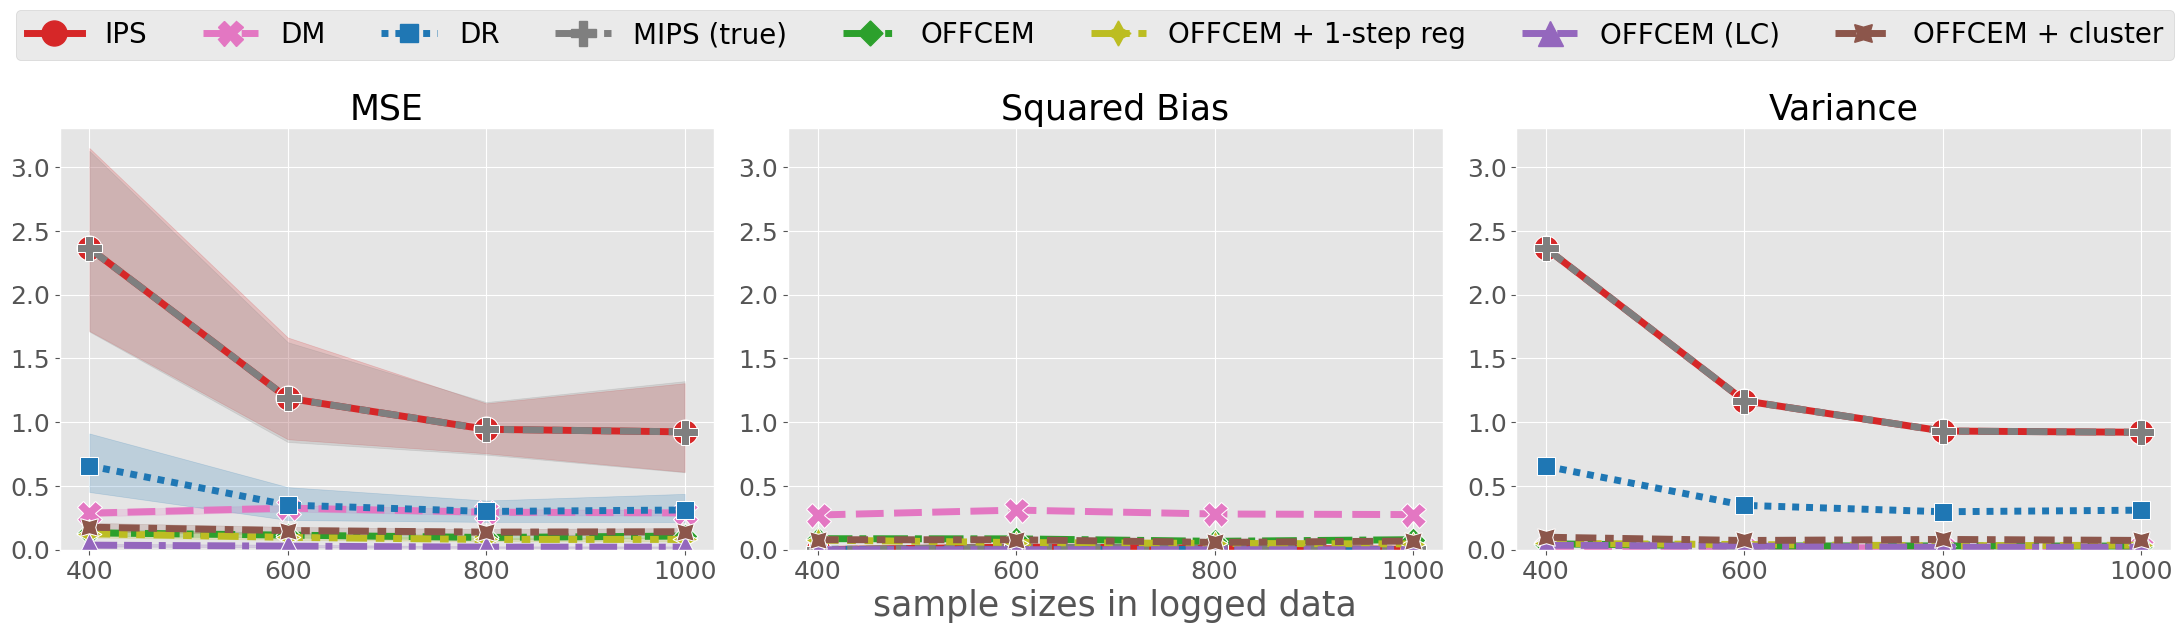

In [6]:
visualize_mean_squared_error(
    result_df=result_df,
    xlabel="sample sizes in logged data",
    yscale="linear"
)

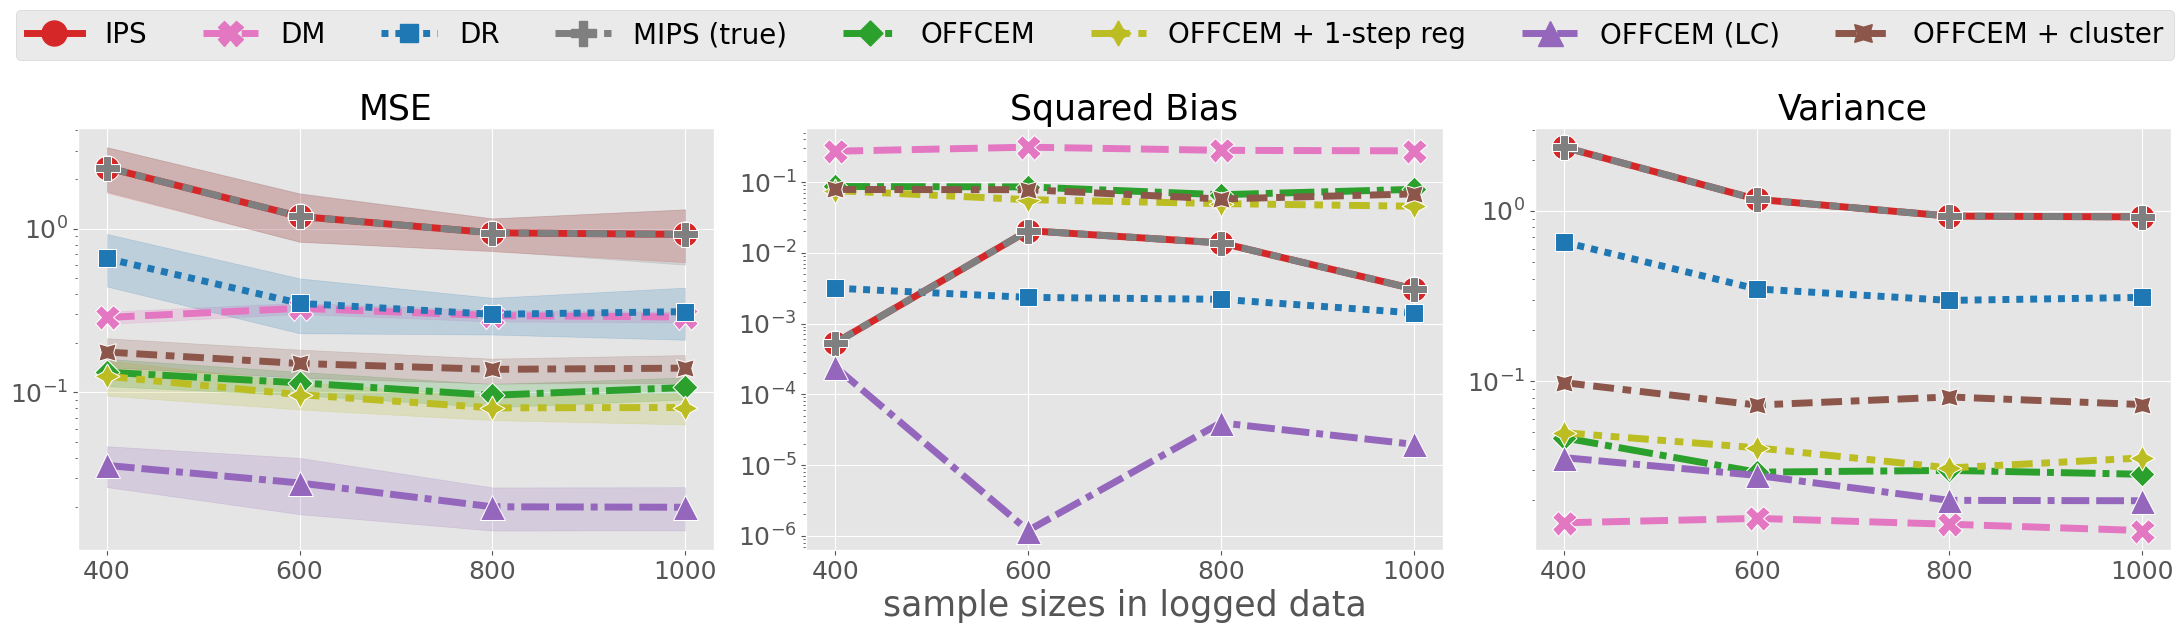

In [7]:
visualize_mean_squared_error(
    result_df=result_df,
    xlabel="sample sizes in logged data",
    yscale="log"
)

In [8]:
result_df.groupby(["estimator", "x"]).agg({"value": "mean"})

value
estimator           x             
DM                  400   1.225341
                    600   1.189806
                    800   1.217837
                    1000  1.222217
DR                  400   1.691009
                    600   1.698807
                    800   1.700293
                    1000  1.709578
IPS                 400   1.724075
                    600   1.603957
                    800   1.629812
                    1000  1.802762
MIPS (true)         400   1.724075
                    600   1.603957
                    800   1.629812
                    1000  1.802762
OFFCEM              400   1.453279
                    600   1.455300
                    800   1.490075
                    1000  1.466538
OFFCEM (LC)         400   1.731627
                    600   1.746099
                    800   1.753472
                    1000  1.742759
OFFCEM + 1-step reg 400   1.472109
                    600   1.509962
                    800   1.524617
                    1000  1.534002
OFFCEM + cluster    400   1.467152
                    600   1.468201
                    800   1.507277
                    1000  1.486719

In [9]:
# OFFCEM underestimated the policy value
policy_value

1.7471879609517302